In [65]:
#Python version
!python --version

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.


In [66]:
#Install uninstalled modules, comment if it's already installed

#!pip install tensorflow==1.15 finta stable-baselines MetaTrader5 gym gym-anytrading quantstats

In [67]:
#Import needed modules
import gym
import gym_anytrading
from gym_anytrading.envs import ForexEnv

import numpy as np
import quantstats as qs

from stable_baselines.a2c import A2C
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpLstmPolicy
from stable_baselines.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

import matplotlib.pyplot as plt
import pandas as pd
from finta import TA

import datetime, os, pytz
import MetaTrader5 as mt5

In [68]:
#Trading Account Parameter
account = 647545 #Account number
password = "QpjpAGkK" #Password number
server = "FBS-Demo" #Server name
mt5_path = "C:\Program Files\FBS MetaTrader 5\terminal64.exe" #path of Metatrader5 director

mt5.initialize(
   path = mt5_path,          # path to the MetaTrader 5 terminal EXE file
   login = account,          # account number
   password = password,      # password
   server = server,          # server name as it is specified in the terminal
   #timeout = TIMEOUT,       # timeout
   portable = False          # portable mode
   )

# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__,"\n")

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize failed, error code =",mt5.last_error())
    mt5.shutdown()
else:
    print("MetaTrader5 Initialized!")

# extract account information and turn it into dataframe   
authorized=mt5.login(account, password, server)
if authorized:
    # display trading account data 'as is'
    print("Metatrader5 authorized!")
    account_info_dict = mt5.account_info()._asdict()
    Acc_Info = pd.DataFrame(list(account_info_dict.items()),columns=['property','value'])
    print("\n", "account_info() as dataframe:")
    print(Acc_Info)
else:
    print("Metatrader5 cant authorize, error code: {}".format(mt5.last_error()))

MetaTrader5 package author:  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.34 

MetaTrader5 Initialized!
Metatrader5 authorized!

 account_info() as dataframe:
              property             value
0                login            647545
1           trade_mode                 0
2             leverage              1000
3         limit_orders               100
4       margin_so_mode                 0
5        trade_allowed              True
6         trade_expert              True
7          margin_mode                 2
8      currency_digits                 2
9           fifo_close             False
10             balance            100000
11              credit                 0
12              profit                 0
13              equity            100000
14              margin                 0
15         margin_free            100000
16        margin_level                 0
17      margin_so_call                40
18        margin_so_so                20
19    

In [69]:
#Extract Account info from dataframe
leverage = Acc_Info.loc[2, "value"]
equity = Acc_Info.loc[13, "value"]
margin_free = Acc_Info.loc[15, "value"]

print(leverage)
print(equity)
print(margin_free)

1000
100000.0
100000.0


In [70]:
# extract information from pair and timeframe
Symbol = "EURUSD"
Timeframe = mt5.TIMEFRAME_D1
symbol_info = mt5.symbol_info(Symbol)
if symbol_info!=None:
    # display the terminal data 'as is'    
    print(symbol_info)
    print("\n","{}: spread =".format(Symbol),symbol_info.spread,"  digits =",symbol_info.digits, "\n")
    # Extract symbol info
    
    print(symbol_info[3])

SymbolInfo(custom=False, chart_mode=0, select=True, visible=True, session_deals=0, session_buy_orders=0, session_sell_orders=0, volume=0, volumehigh=0, volumelow=0, time=1624497435, digits=5, spread=10, spread_float=True, ticks_bookdepth=0, trade_calc_mode=0, trade_mode=4, start_time=0, expiration_time=0, trade_stops_level=1, trade_freeze_level=0, trade_exemode=2, swap_mode=1, swap_rollover3days=3, margin_hedged_use_leg=False, expiration_mode=15, filling_mode=3, order_mode=127, order_gtc_mode=0, ...)

 EURUSD: spread = 10   digits = 5 

True


In [71]:
# set time zone to UTC
timezone = pytz.timezone("Etc/UTC")

# getbars from the current day
bar = 500
rates = mt5.copy_rates_from_pos(Symbol, Timeframe, 0, bar)
 
# create DataFrame out of the obtained data
rates_frame = pd.DataFrame(rates, dtype=np.dtype("float"))
# convert time in seconds into the datetime format
rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
                           
# display data
print("\nDisplay dataframe with data")
print(rates_frame)

# turn rates frame into csv file
rates_frame.to_csv('./Datasets/{}.csv'.format(Symbol), index=False)
pd.read_csv('./Datasets/{}.csv'.format(Symbol))


Display dataframe with data
          time     open     high      low    close  tick_volume  spread  \
0   2019-07-22  1.12144  1.12244  1.12052  1.12080      48433.0     8.0   
1   2019-07-23  1.12080  1.12087  1.11450  1.11507      50464.0     8.0   
2   2019-07-24  1.11508  1.11550  1.11261  1.11391      51590.0     8.0   
3   2019-07-25  1.11392  1.11869  1.11006  1.11455      64621.0     8.0   
4   2019-07-26  1.11455  1.11499  1.11112  1.11229      52303.0     8.0   
..         ...      ...      ...      ...      ...          ...     ...   
495 2021-06-18  1.19034  1.19212  1.18436  1.18584      63688.0     4.0   
496 2021-06-21  1.18541  1.19197  1.18459  1.19099      76173.0     4.0   
497 2021-06-22  1.19134  1.19508  1.18791  1.19315      63425.0     4.0   
498 2021-06-23  1.19342  1.19683  1.19096  1.19200      59965.0     4.0   
499 2021-06-24  1.19231  1.19307  1.19225  1.19296        211.0     0.0   

     real_volume  
0            0.0  
1            0.0  
2            

,time,open,high,low,close,tick_volume,spread,real_volume
0,2019-07-22,1.12144,1.12244,1.12052,1.12080,48433.0,8.0,0.0
1,2019-07-23,1.12080,1.12087,1.11450,1.11507,50464.0,8.0,0.0
2,2019-07-24,1.11508,1.11550,1.11261,1.11391,51590.0,8.0,0.0
3,2019-07-25,1.11392,1.11869,1.11006,1.11455,64621.0,8.0,0.0
4,2019-07-26,1.11455,1.11499,1.11112,1.11229,52303.0,8.0,0.0
...,...,...,...,...,...,...,...,...
495,2021-06-18,1.19034,1.19212,1.18436,1.18584,63688.0,4.0,0.0
496,2021-06-21,1.18541,1.19197,1.18459,1.19099,76173.0,4.0,0.0
497,2021-06-22,1.19134,1.19508,1.18791,1.19315,63425.0,4.0,0.0
498,2021-06-23,1.19342,1.19683,1.19096,1.19200,59965.0,4.0,0.0


In [73]:
# read csv from datasets folder
df = pd.read_csv('./Datasets/{}.csv'.format(Symbol))

# turn time coloumn into datetime
df['time'] = pd.to_datetime(df['time'])

#delete empty coloumn
del df['real_volume']

# make indicator coloumns to the dataframe
df['EMA60'] = TA.EMA(df, 60, 'open')
df['EMA120'] = TA.EMA(df, 120, 'open')
df['EMA240'] = TA.EMA(df, 240, 'open')
df['RSI'] = TA.RSI(df, 14, 'open')
df['ATR'] = TA.ATR(df, 14)
df.fillna(0, inplace=True)

#  rename coloumn's name
df = df.rename(columns={
    "time":"Date",
    "open":"Open",
    "high":"High",
    "low":"Low",
    "close":"Close",
    "tick_volume":"Tick_volume",
    "spread":"Spread",
})

# set Date coloumn as index
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Tick_volume,Spread,EMA60,EMA120,EMA240,RSI,ATR
Date,,,,,,,,,,,
2019-07-22,1.12144,1.12244,1.12052,1.12080,48433.0,8.0,1.121440,1.121440,1.121440,0.000000,0.000000
2019-07-23,1.12080,1.12087,1.11450,1.11507,50464.0,8.0,1.121115,1.121117,1.121119,0.000000,0.000000
2019-07-24,1.11508,1.11550,1.11261,1.11391,51590.0,8.0,1.119036,1.119071,1.119089,0.000000,0.000000
2019-07-25,1.11392,1.11869,1.11006,1.11455,64621.0,8.0,1.117692,1.117751,1.117781,0.000000,0.000000
2019-07-26,1.11455,1.11499,1.11112,1.11229,52303.0,8.0,1.117021,1.117089,1.117124,8.809213,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-18,1.19034,1.19212,1.18436,1.18584,63688.0,4.0,1.208767,1.203386,1.189825,30.110550,0.007124
2021-06-21,1.18541,1.19197,1.18459,1.19099,76173.0,4.0,1.208002,1.203089,1.189788,27.582423,0.007345
2021-06-22,1.19134,1.19508,1.18791,1.19315,63425.0,4.0,1.207455,1.202895,1.189801,34.686026,0.007399


In [74]:
# make a custom signal parameter from a spesific data
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Open'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Open', 'EMA60', 'EMA120','EMA240' , 'RSI']].to_numpy()[start:end]
    return prices, signal_features

class MyCustomEnv(ForexEnv):
    _process_data = add_signals


env information:
> shape: (12, 5)
> df.shape: (500, 11)
> prices.shape: (500,)
> signal_features.shape: (500, 5)
> max_possible_profit: 2.1744312276265876


> possible action: Discrete(2)
> observation space: Box(-inf, inf, (12, 5), float32)


> signal features:  [[ 1.12144     1.12144     1.12144     1.12144     0.        ]
 [ 1.1208      1.12111467  1.12111733  1.12111867  0.        ]
 [ 1.11508     1.11903569  1.11907126  1.11908898  0.        ]
 ...
 [ 1.19134     1.20745531  1.20289489  1.18980079 34.68602599]
 [ 1.19342     1.20699513  1.20273825  1.1898313  37.01966131]
 [ 1.19231     1.20651365  1.20256584  1.1898522  36.27479863]]


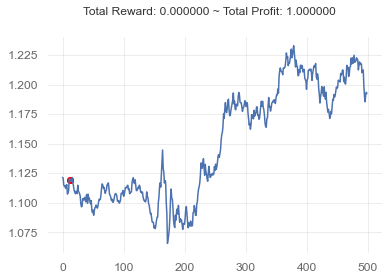

               Open     High      Low    Close  Tick_volume  Spread     EMA60  \
Date                                                                            
2019-07-22  1.12144  1.12244  1.12052  1.12080      48433.0     8.0  1.121440   
2019-07-23  1.12080  1.12087  1.11450  1.11507      50464.0     8.0  1.121115   
2019-07-24  1.11508  1.11550  1.11261  1.11391      51590.0     8.0  1.119036   
2019-07-25  1.11392  1.11869  1.11006  1.11455      64621.0     8.0  1.117692   
2019-07-26  1.11455  1.11499  1.11112  1.11229      52303.0     8.0  1.117021   
...             ...      ...      ...      ...          ...     ...       ...   
2021-06-18  1.19034  1.19212  1.18436  1.18584      63688.0     4.0  1.208767   
2021-06-21  1.18541  1.19197  1.18459  1.19099      76173.0     4.0  1.208002   
2021-06-22  1.19134  1.19508  1.18791  1.19315      63425.0     4.0  1.207455   
2021-06-23  1.19342  1.19683  1.19096  1.19200      59965.0     4.0  1.206995   
2021-06-24  1.19231  1.19307

In [75]:
# build the gym environment
window_size = 12
start_index = window_size
end_index = len(df)
env = MyCustomEnv(df = df,
               window_size = start_index,
               frame_bound = (start_index, end_index), #Max 6225 Rows of data
               unit_side = 'right')

# get information from the environment
print()
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())
print("\n")
print("> possible action:", env.action_space)
print("> observation space:", env.observation_space)
print("\n")
print("> signal features: ", env.signal_features)

env.reset() # Uncomment if you need it.
env.render()

print(env.df)
print("\n")
env.df.info()

info: {'total_reward': -457.40000000001413, 'total_profit': 0.9766801214002055, 'position': 1}


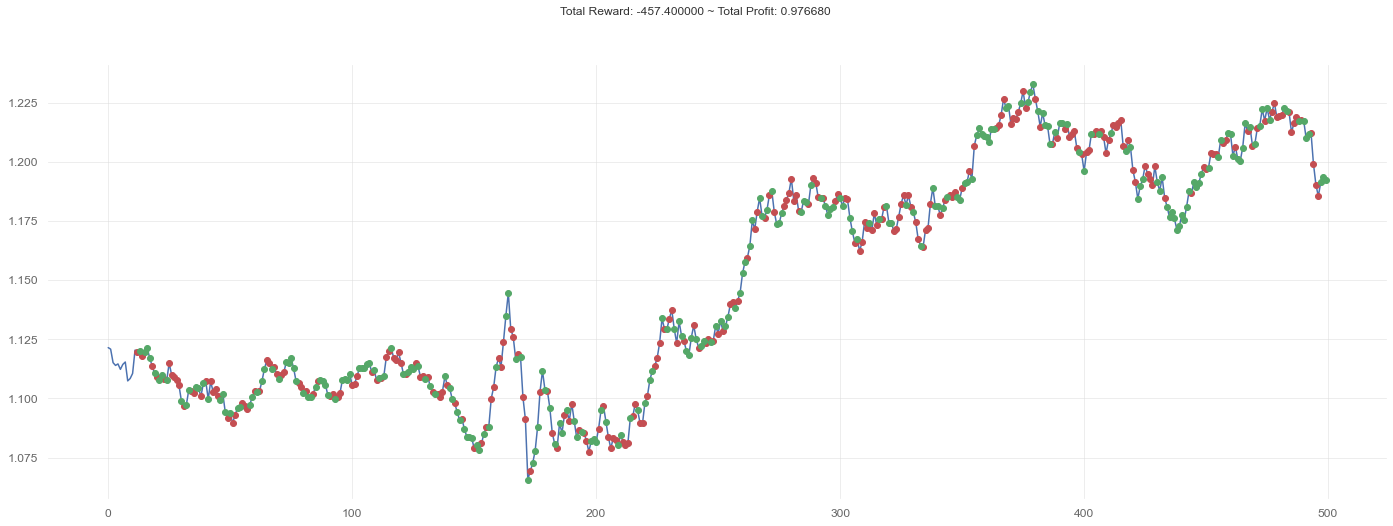

Date
2019-08-09   -0.001929
2019-08-12    0.000000
2019-08-13    0.000000
2019-08-14    0.000000
2019-08-15   -0.005680
                ...   
2021-06-18    0.000000
2021-06-21    0.000000
2021-06-22    0.000000
2021-06-23    0.000000
2021-06-24    0.000562
Length: 486, dtype: float64 



                           Strategy
-------------------------  ----------
Start Period               2019-08-09
End Period                 2021-06-24
Risk-Free Rate             0.0%
Time in Market             28.0%

Cumulative Return          -2.33%
CAGR%                      -1.25%

Sharpe                     -0.24
Sortino                    -0.35
Sortino/√2                 -0.25

Max Drawdown               -5.8%
Longest DD Days            595
Volatility (ann.)          4.69%
Calmar                     -0.22
Skew                       1.5
Kurtosis                   21.15

Expected Daily %           -0.0%
Expected Monthly %         -0.1%
Expected Yearly %          -0.78%
Kelly Criterion            -4.12%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.49%
Expected Shortfall (cVaR)  -0.49%

Gain/Pain Ratio            -0.07
Gain/Pain (1M)             -0.19

Payoff Ratio               0.86
Profit Factor              0.93
Common Sense Ratio         0.77
CPC Index             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-11-07,2021-02-04,2021-06-24,595,-5.799866,-5.483279
2,2019-09-27,2019-10-01,2019-10-21,24,-1.119938,-0.941273
3,2019-08-15,2019-08-19,2019-09-06,22,-0.727342,-0.695078
4,2019-09-12,2019-09-12,2019-09-18,6,-0.367554,-0.312617


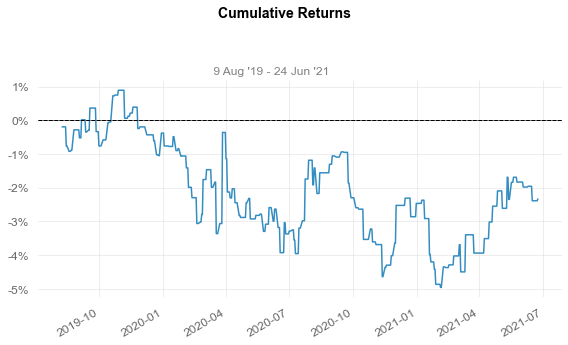

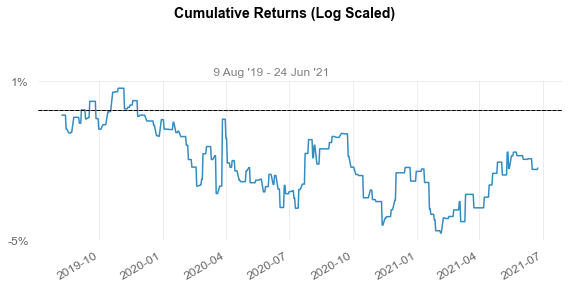

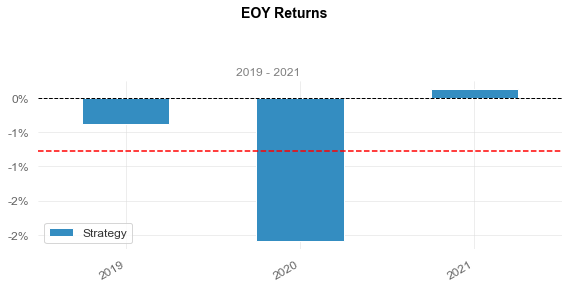

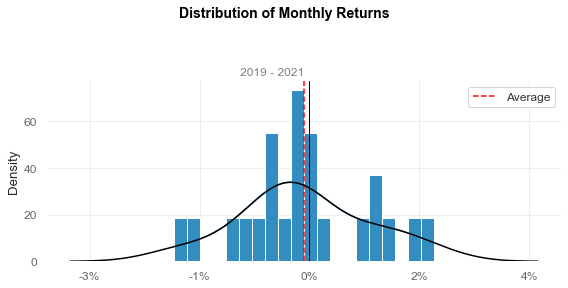

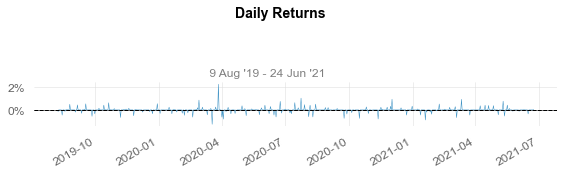

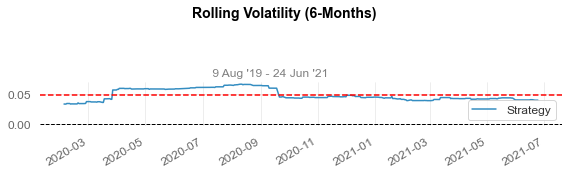

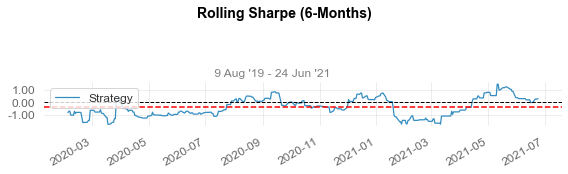

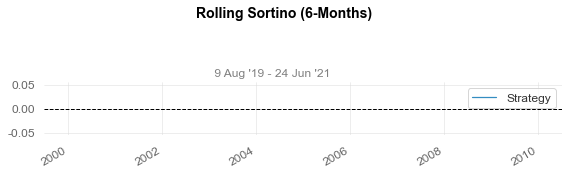

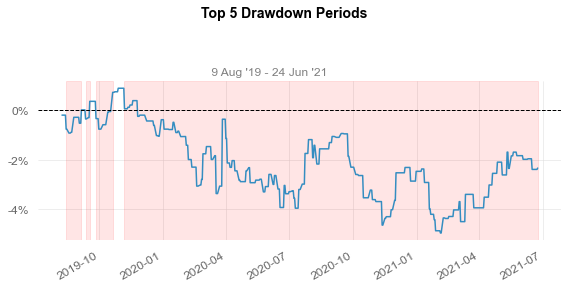

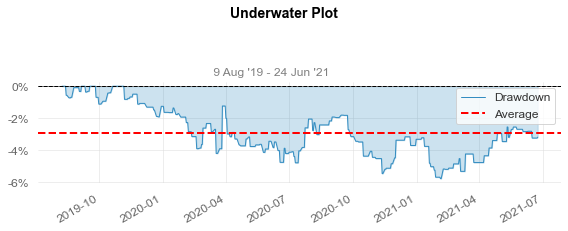

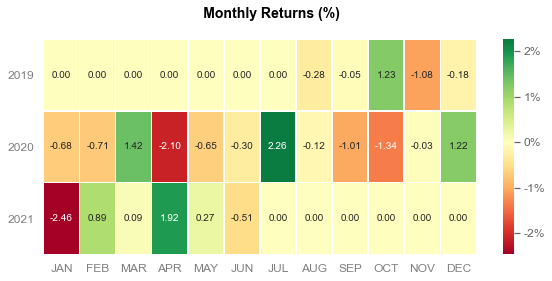

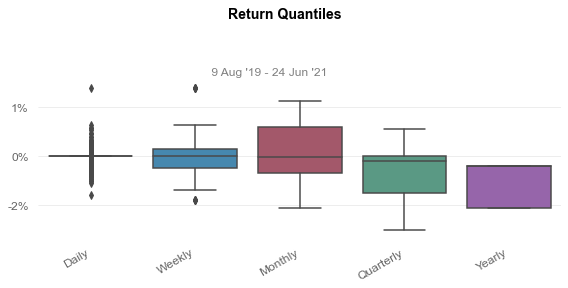

In [72]:
# make a prediction based on random actions

observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.figure(figsize=(24, 8))
plt.cla()
env.render_all()
plt.show()

# create a quantstats result for a comparison
qs.extend_pandas()
net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

print(returns,'\n')

qs.reports.full(returns)
qs.reports.html(returns, output='./Random Result/random quantstats.html'.format(Symbol, Timeframe))

In [59]:
env_maker = lambda: env
env = DummyVecEnv([env_maker])

In [54]:
timesteps = 50000

eval_callback = EvalCallback(
    env,
    best_model_save_path='./Saved_Model/{}-{}-Model_{}'.format(Symbol, Timeframe, timesteps),
    log_path='./logs/{}_{}'.format(Symbol, Timeframe),
    eval_freq=100,
    deterministic=True,
    render=False,
    )

policy_kwargs = dict(net_arch=[32, 32, 'lstm'])

model = A2C(
    'MlpLstmPolicy',
    env,
    gamma=0.95,
    learning_rate=0.002,
    verbose=1,
    policy_kwargs=policy_kwargs,
    ) 

model.learn(
    total_timesteps=timesteps,
    callback=eval_callback,
    )

## model.save('./Saved_Model/{}-{}-Model_{}/best_model.zip'.format(Symbol, Timeframe, timesteps))

---------------------------------
| explained_variance | 8.82e-05 |
| fps                | 15       |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 5        |
| value_loss         | 2.38e+04 |
---------------------------------
Eval num_timesteps=100, episode_reward=-1000.00 +/- 0.00
Episode length: 487.00 +/- 0.00
New best mean reward!
Eval num_timesteps=200, episode_reward=-1120.00 +/- 0.00
Episode length: 487.00 +/- 0.00


KeyboardInterrupt: 

In [60]:
env = MyCustomEnv(df = df,
               window_size = start_index,
               frame_bound = (start_index, end_index), #Max 6225 Rows of data
               unit_side = 'right')

# delete model dan loading from saved folder, comment if you didn't need it
# del model # remove model for saving and loading
## model = A2C.load('./Saved_Model/{}-{}-Model_{}/best_model.zip'.format(Symbol, Timeframe, timesteps))
model = A2C.load('D:\TugasKampus\Fun Project\MT5_TensorDL\model vault\Best-Trained-13062021/best_model.zip')

observation = env.reset()

while True:
    observation = observation[np.newaxis, ...]

    action, _states = model.predict(observation)
    observation, reward, done, info = env.step(action)

    if done:
        print("info:", info)
        break

Loading a model without an environment, this model cannot be trained until it has a valid environment.
info: {'total_reward': -1825.2999999999854, 'total_profit': 0.9228434657755255, 'position': 0}


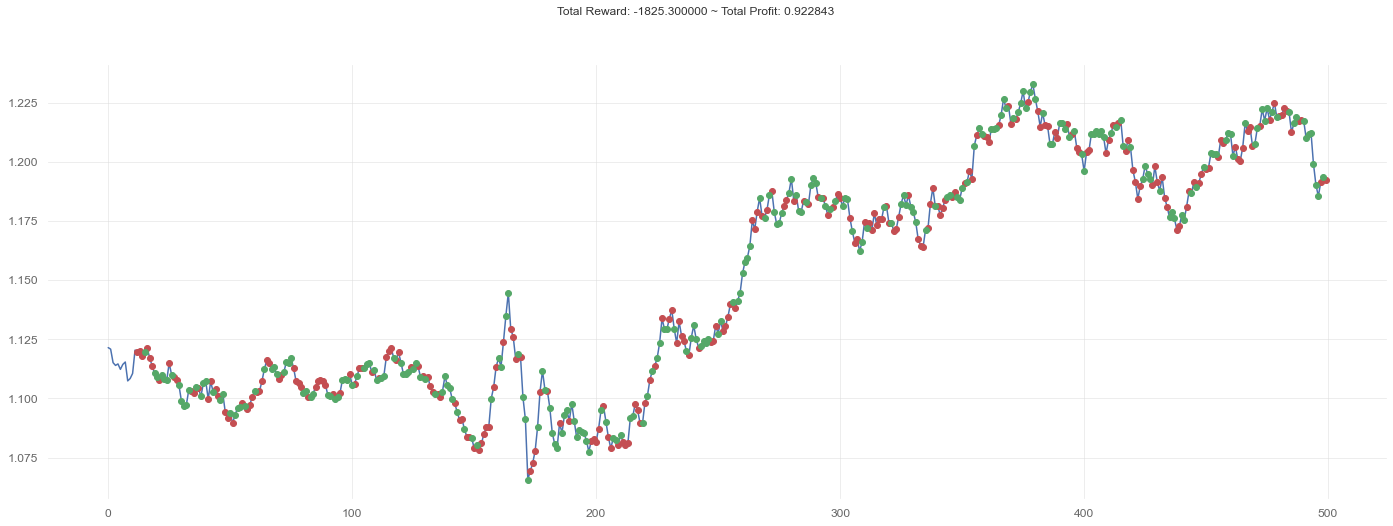

In [61]:
# gets result from trained model
plt.figure(figsize=(24, 8))
env.render_all()
plt.show()

Date
2019-08-09    0.000000
2019-08-12    0.000000
2019-08-13    0.001170
2019-08-14    0.000000
2019-08-15    0.000000
                ...   
2021-06-18    0.000000
2021-06-21    0.000000
2021-06-22   -0.021588
2021-06-23    0.000000
2021-06-24   -0.001181
Length: 486, dtype: float64 



                           Strategy
-------------------------  ----------
Start Period               2019-08-09
End Period                 2021-06-24
Risk-Free Rate             0.0%
Time in Market             26.0%

Cumulative Return          -7.72%
CAGR%                      -4.19%

Sharpe                     -0.83
Sortino                    -1.09
Sortino/√2                 -0.77

Max Drawdown               -7.96%
Longest DD Days            535
Volatility (ann.)          4.89%
Calmar                     -0.53
Skew                       -0.51
Kurtosis                   40.07

Expected Daily %           -0.02%
Expected Monthly %         -0.35%
Expected Yearly %          -2.64%
Kelly Criterion            -17.17%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.52%
Expected Shortfall (cVaR)  -0.52%

Gain/Pain Ratio            -0.27
Gain/Pain (1M)             -0.5

Payoff Ratio               0.87
Profit Factor              0.73
Common Sense Ratio         0.5
CPC Index         

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-06,2021-06-24,2021-06-24,535,-7.961340,-6.280321
2,2019-08-28,2019-10-01,2019-12-30,124,-1.386906,-1.359530
3,2019-08-20,2019-08-20,2019-08-26,6,-0.285449,0.000000


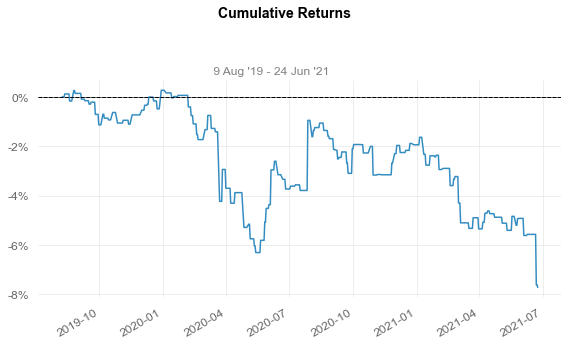

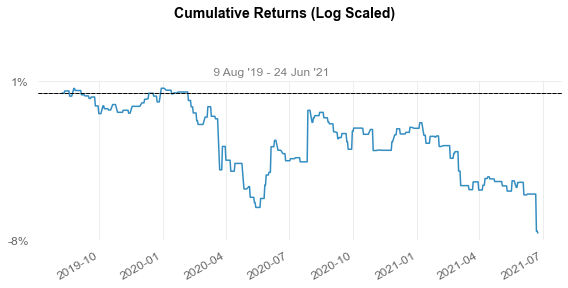

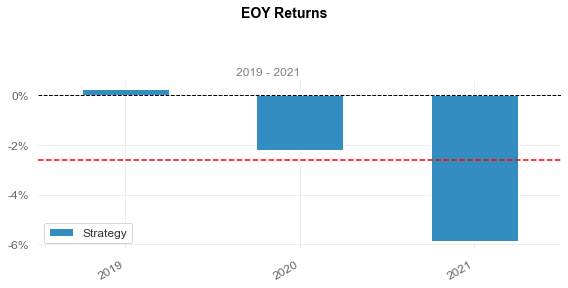

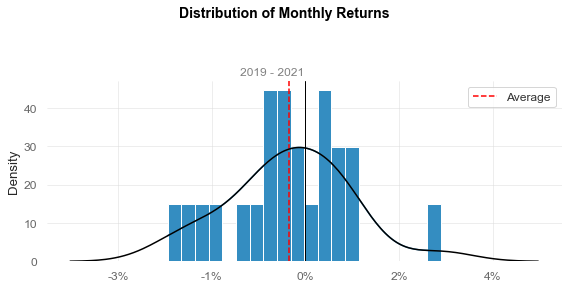

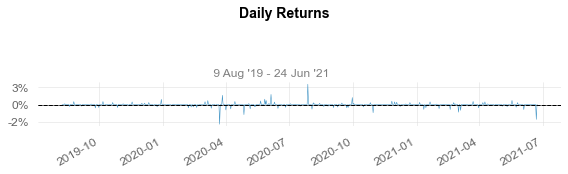

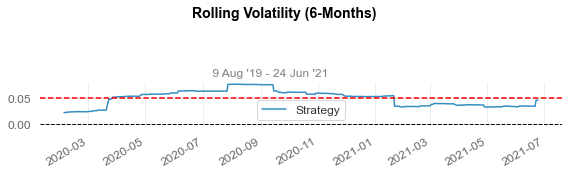

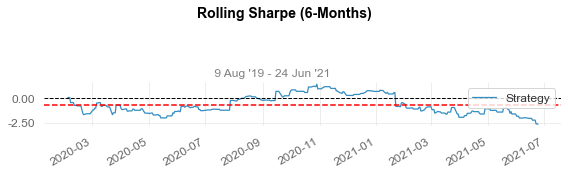

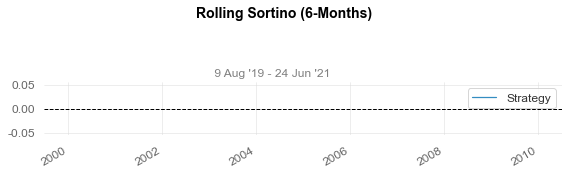

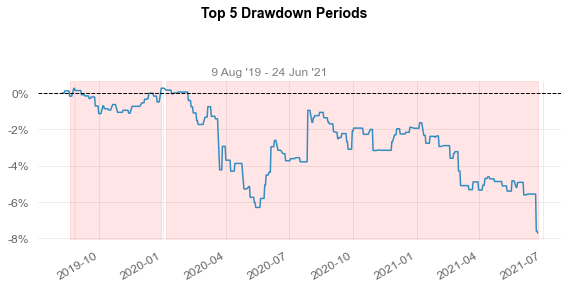

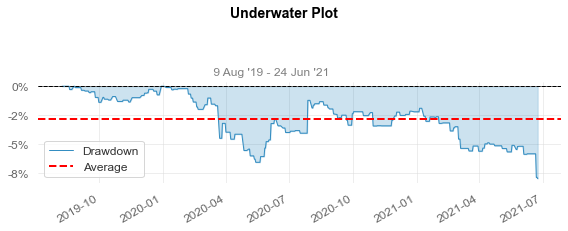

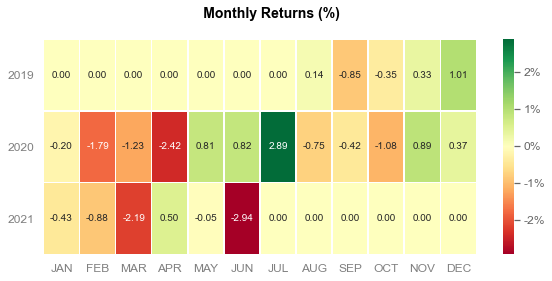

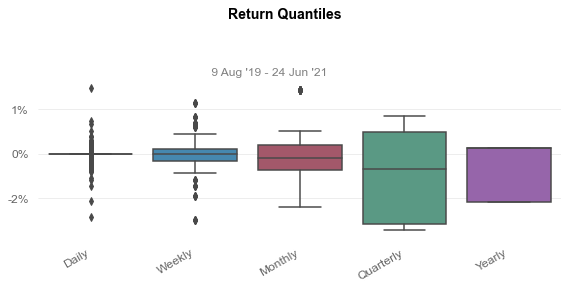

NameError: name 'timesteps' is not defined

In [62]:
# gets full result from trained model
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

print(returns,'\n')

qs.reports.full(returns)
qs.reports.html(returns, output='./Backtesting/{}_{}_{}_quantstats.html'.format(Symbol, Timeframe, timesteps))